# Cirrhosis Outcome Prediction


# Import our packages

In [59]:
# Import core packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

# import our models
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import log_loss
from sklearn.preprocessing import RobustScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from xgboost import XGBClassifier
from sklearn.ensemble import (
    RandomForestClassifier,
    AdaBoostClassifier,
    StackingClassifier,
    VotingClassifier,
)
from catboost import CatBoostClassifier
from sklearn.neural_network import MLPClassifier

In [60]:
# Create our palette
palette = sns.color_palette(
    [
        "#86C2DA",
        "#D0C1AA",
        "#D98594",
        "#C0DDE1",
        "#E9DBD0",
        "#8E8C8F",
        "#9A9AA2",
    ],
)
# Create a diverging palette from our original palette
div_palette = sns.color_palette("blend:#86C2DA,#D98594")

# Set the base palette as default
sns.set_palette(palette)

# Read our Data

In [61]:
# read in the data
test = pd.read_csv("./data/test.csv")
train = pd.read_csv("./data/train.csv")

We can also standardize our column headers in order to make them more efficient to work with

In [62]:
def clean_column_labels(df):
    df.columns = df.columns.str.lower().str.replace(" ", "_")
    return df

In [63]:
train = clean_column_labels(train)
test = clean_column_labels(test)

Lets take a look at our train dataset

In [64]:
train.head()

,id,n_days,drug,age,sex,ascites,hepatomegaly,spiders,edema,bilirubin,cholesterol,albumin,copper,alk_phos,sgot,tryglicerides,platelets,prothrombin,stage,status
0,0,999,D-penicillamine,21532,M,N,N,N,N,2.3,316.0,3.35,172.0,1601.0,179.80,63.0,394.0,9.7,3.0,D
1,1,2574,Placebo,19237,F,N,N,N,N,0.9,364.0,3.54,63.0,1440.0,134.85,88.0,361.0,11.0,3.0,C
2,2,3428,Placebo,13727,F,N,Y,Y,Y,3.3,299.0,3.55,131.0,1029.0,119.35,50.0,199.0,11.7,4.0,D
3,3,2576,Placebo,18460,F,N,N,N,N,0.6,256.0,3.50,58.0,1653.0,71.30,96.0,269.0,10.7,3.0,C
4,4,788,Placebo,16658,F,N,Y,N,N,1.1,346.0,3.65,63.0,1181.0,125.55,96.0,298.0,10.6,4.0,C


# Data Exploration

In order to get a better undestanding of the dataset we are working with we will conduct an exploritory analysis of the dataset.<br>
The target variables for our analysis, and eventually our models will be the `status` variable which indicates the status of patients as one of three options:
- C: Censored
- CL: Censored and liver transplant
- D: Death

The values will be formed into a distribution and plotted as a histogram. The values of the categorical variables of the dataset will be plotted using a countplot.

## Overview

The train dataset contains 7905 rows and 20 columns. The test dataset contains 5271 rows and 19 columns.

Neither dataset contains any null values which allows us to jump directly into our exploratory analysis without the need imputing prior. 

The exploration will be done primarily with the train dataset, however the two datasets will be compared in order to determine if the distribution of categorical variables is similar between both datasets. 

##### We have three types of variables in ourdata set: Categorical, Numeric, and Descriptive.<br>

The descriptive variables in our data set are:
- `id`: Patient ID

The categorical variables in our data set are:
- `drug`: Drug used for treatment
- `sex`: Sex of the patient (M/F)
- `ascites`: Presence of Ascites (N/Y)
- `hepatomegaly`: Presence of hepatomegaly (N/Y)
- `spiders`: Presence of spiders (N/Y)
- `edema`: Presence of edema
- `status`: Status of patient
- `stage`: histological stage of disease

The numeric variables in our data set are:
- `age`: Age of patient
- `bilirubin`: Bilirubin levels
- `cholesterol`: Cholesterol levels
- `albumin`: Albumin levels
- `copper`: Urine copper levels
- `alk_phos`: Alkaline phosphotase levels
- `sgot`: SGOT levels
- `triglicerides`: Trigliceride levels
- `platelets`: Platelet levels
- `prothrombin`: Prothrombin activity


In [65]:
# Find the number of nulls in the dataset
train_nulls = train.isnull().sum().sum()
test_nulls = test.isnull().sum().sum()

print(
    f"There are {train_nulls} nulls in the train dataset and {test_nulls} nulls in the test dataset."
)

There are 0 nulls in the train dataset and 0 nulls in the test dataset.


We can drop the `id` column at this point since it does not provide and useful information for our models. We can also create lists of our categorical and numeric column names

In [66]:
# drop id
train.drop("id", axis=1, inplace=True)
test.drop("id", axis=1, inplace=True)

# Find our categorical and numeric variables
cat_vars = list(train.select_dtypes(include=["object"]).columns)
num_vars = list(train.select_dtypes(exclude=["object"]).columns)

## Target Variable

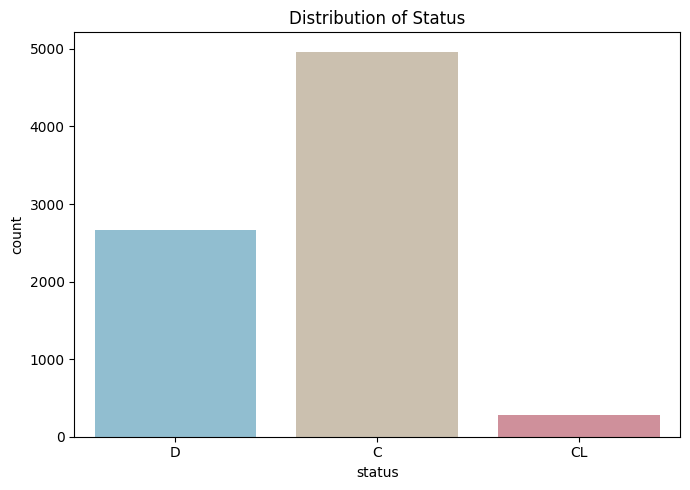

In [67]:
plt.figure(figsize=(7, 5))
sns.countplot(
    data=train, x="status", hue="status", legend=False, palette=palette[:3]
)
plt.title("Distribution of Status")
plt.tight_layout()
plt.show()

## Categorical Variables

We will take a look at each categorical variable by creating a count plot of each value for each variable. We can also compare the distribution of values for each categorical variables between our train and test dataset. It is important to ensure that there is a similar distribution between our test and train datasets, especially when there rare so many categorical variables.

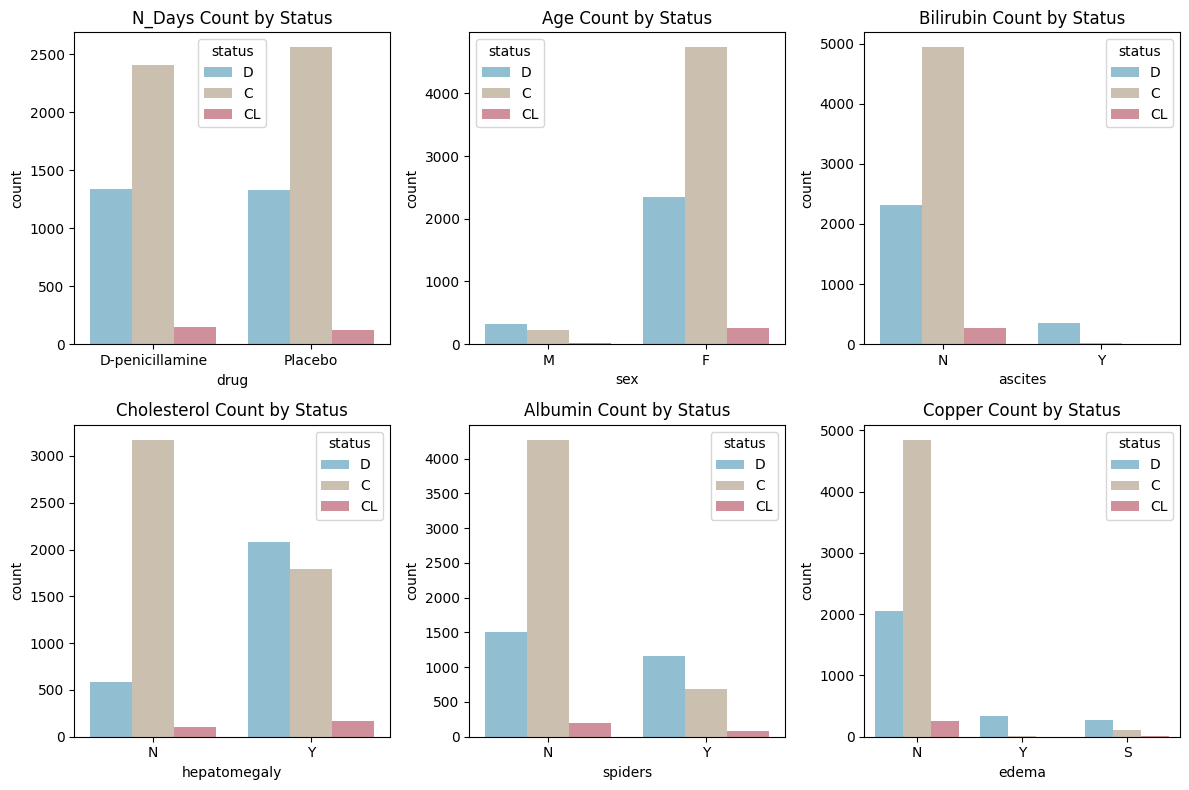

In [68]:
fig, axes = plt.subplots(2, 3, figsize=(12, 8))
for i, ax in enumerate(axes.flatten()):
    sns.countplot(
        data=train, hue="status", x=cat_vars[i], ax=ax, palette=palette[:3]
    )
    ax.set_title(f"{num_vars[i].title()} Count by Status")
plt.tight_layout()
plt.show()

## Numeric Variables

Now we can take a look at our numeric variables. First we will investigate the distributions of the numeric variables, and then we can look at the relationship between the numeric variables and our target variable.

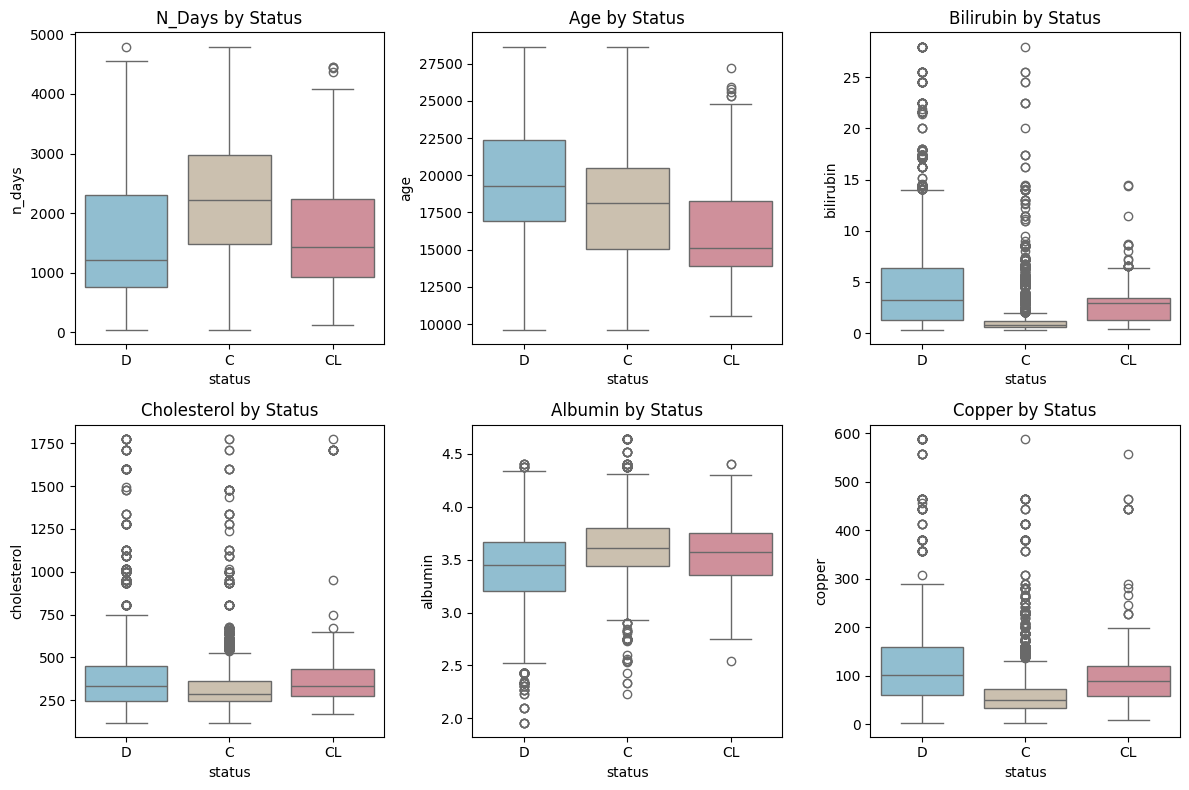

In [69]:
fig, axes = plt.subplots(2, 3, figsize=(12, 8))
for i, ax in enumerate(axes.flatten()):
    sns.boxplot(
        data=train,
        x="status",
        hue="status",
        y=num_vars[i],
        legend=False,
        ax=ax,
        palette=palette[:3],
    )
    ax.set_title(f"{num_vars[i].title()} by Status")
plt.tight_layout()
plt.show()

# Model Building


## Feature and Target Selection

The target for this analysis is the `status` column, which indicates the status of the patient. This will be selected as our target, and the other variables in our dataset will be selected as our features.


In [70]:
X = train.copy().drop(columns=["status"], axis=1)
y = train.copy()["status"].map(
    {"C": 0, "CL": 1, "D": 2}
)  ## TODO Potentialy map these to numeric values

## Model Evaluation

We will be using **4** main models for this analysis:
- RandomForestClasifier
- AdaBoost
- CatBoost
- XGBoost

Each of the four models will be created and evaluated using our training dataset. 

These models will then be used in a series on model ensembles and compared. These ensembles include using a stacking classifier with a sklearn neural net classifier as the final estimator, and a voting classifier which ways the  outcomes of the 4 main models. 

The best performing model will be used to predict the outcomes of the test dataset.

In [71]:
# Four main models
xgb = XGBClassifier(random_state=42)
ada = AdaBoostClassifier(random_state=42)
rf = RandomForestClassifier(random_state=42)
cat = CatBoostClassifier(random_state=42)

# Secondary ensemble models
mlp = MLPClassifier()
stack = StackingClassifier(
    estimators=[("rf", rf), ("ada", ada), ("cat", cat), ("xgb", xgb)],
    final_estimator=mlp,
)
voting = VotingClassifier(
    estimators=[("rf", rf), ("ada", ada), ("cat", cat), ("xgb", xgb)],
    voting="soft",
)

## Pipeline Creation

We will start by creating a preprocessing pipeline which will be used to transform our data prior to modeling. This pipeline will be used to transform both our training and test datasets.

In [72]:
num_vars = list(X.select_dtypes(exclude=["object"]).columns)
cat_vars = list(X.select_dtypes(include=["object"]).columns)

In [73]:
preprocess = ColumnTransformer(
    transformers=[
        ("num", RobustScaler(), num_vars),
        ("cat", OneHotEncoder(handle_unknown="ignore"), cat_vars),
    ]
)

We used the robust scaler from scikit learn in order to scale our data. Scaling our data is crucial in order to get good results because it creates more reliability amongst our values. We also encoded our categorical values using OneHotEncoder. This is important because it allows us to use our categorical variables in our models.

In [74]:
base_models = [("rf", rf), ("ada", ada), ("cat", cat), ("xgb", xgb)]

We can start by preprocessing our training dataset. We wll then use to prepped data to pass into each of our four base models. The results will be evaluated and the best performing model will be used to predict the outcomes of the test dataset. We will be testing the log loss of each model.

In [75]:
X_prep = preprocess.fit_transform(X)

We can make a function which we can use to test each of base models using a stratified kfold cross validation. This will allow us to get a better idea of how each model performs on our dataset. We will also be able to see how the models perform on different splits of the data.

In [76]:
def test_model(model, model_name, X, y):
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    scores = []
    models = []
    for train_idx, test_idx in cv.split(X, y):
        X_train, y_train = X[train_idx], y[train_idx]
        X_test, y_test = X[test_idx], y[test_idx]
        model.fit(X_train, y_train)
        preds = model.predict_proba(X_test)
        scores.append(log_loss(y_test, preds))
        models.append(model)
    print(f"{model_name} CV Log Loss: {np.mean(scores)}")
    return (models, scores)

In [77]:
model_results = {}
for name, model in base_models:
    results = test_model(model, name, X_prep, y)
    model_results[name] = {}
    model_results[name]["models"] = results[0]
    model_results[name]["scores"] = results[1]
print()
model_results

rf CV Log Loss: 0.5378242016952024
ada CV Log Loss: 1.0510757316312094
Learning rate set to 0.086931
0:	learn: 1.0136177	total: 7.9ms	remaining: 7.89s
1:	learn: 0.9438838	total: 13.3ms	remaining: 6.64s
2:	learn: 0.8830820	total: 19.2ms	remaining: 6.38s
3:	learn: 0.8347019	total: 24.8ms	remaining: 6.18s
4:	learn: 0.7943096	total: 30.4ms	remaining: 6.04s
5:	learn: 0.7572158	total: 37.5ms	remaining: 6.22s
6:	learn: 0.7258489	total: 43.8ms	remaining: 6.22s
7:	learn: 0.6999647	total: 50.4ms	remaining: 6.25s
8:	learn: 0.6764964	total: 56.5ms	remaining: 6.22s
9:	learn: 0.6553237	total: 62.5ms	remaining: 6.18s
10:	learn: 0.6372943	total: 68.8ms	remaining: 6.19s
11:	learn: 0.6206564	total: 74.3ms	remaining: 6.12s
12:	learn: 0.6072688	total: 80.1ms	remaining: 6.08s
13:	learn: 0.5938236	total: 87ms	remaining: 6.13s
14:	learn: 0.5812669	total: 92.6ms	remaining: 6.08s
15:	learn: 0.5712705	total: 98.3ms	remaining: 6.04s
16:	learn: 0.5617600	total: 104ms	remaining: 6.03s
17:	learn: 0.5527518	total: 1

{'rf': {'models': [RandomForestClassifier(random_state=42),
   RandomForestClassifier(random_state=42),
   RandomForestClassifier(random_state=42),
   RandomForestClassifier(random_state=42),
   RandomForestClassifier(random_state=42)],
  'scores': [0.5480361035912253,
   0.5474457841469209,
   0.47516878200644613,
   0.5855198272642539,
   0.532950511467166]},
 'ada': {'models': [AdaBoostClassifier(random_state=42),
   AdaBoostClassifier(random_state=42),
   AdaBoostClassifier(random_state=42),
   AdaBoostClassifier(random_state=42),
   AdaBoostClassifier(random_state=42)],
  'scores': [1.052919143915478,
   1.049636509316969,
   1.0525013305232402,
   1.0467585250761626,
   1.0535631493241975]},
 'cat': {'models': [<catboost.core.CatBoostClassifier at 0x26e7d51fbd0>,
  'scores': [0.4554365149802513,
   0.47523013093186484,
   0.4443555293937047,
   0.4687335793798907,
   0.4836517642448378]},
 'xgb': {'models': [XGBClassifier(base_score=None, booster=None, callbacks=None,
           

We can now use the collection of models and score we have generated in order to create an ensemble using the best models;

In [78]:
best_models = []
for classifier in model_results:
    best_models.append(
        (
            classifier,
            model_results[classifier]["models"][
                np.argmin(model_results[classifier]["scores"])
            ],
        )
    )
best_models

[('rf', RandomForestClassifier(random_state=42)),
 ('ada', AdaBoostClassifier(random_state=42)),
 ('cat', <catboost.core.CatBoostClassifier at 0x26e7d51fbd0>),
 ('xgb',
  XGBClassifier(base_score=None, booster=None, callbacks=None,
                colsample_bylevel=None, colsample_bynode=None,
                colsample_bytree=None, device=None, early_stopping_rounds=None,
                enable_categorical=False, eval_metric=None, feature_types=None,
                gamma=None, grow_policy=None, importance_type=None,
                interaction_constraints=None, learning_rate=None, max_bin=None,
                max_cat_threshold=None, max_cat_to_onehot=None,
                max_delta_step=None, max_depth=None, max_leaves=None,
                min_child_weight=None, missing=nan, monotone_constraints=None,
                multi_strategy=None, n_estimators=None, n_jobs=None,
                num_parallel_tree=None, objective='multi:softprob', ...))]

Based on our preliminary results our best model was the CatBoostClassifier at a log loss of 0.46. Our worst model was the AdaBoostClassifier at a log loss of 1.051.

Since the AdaBoostClassifier performed so poorly we will not be using it in our model ensembles.

In [79]:
best_models.pop(1)
best_models

[('rf', RandomForestClassifier(random_state=42)),
 ('cat', <catboost.core.CatBoostClassifier at 0x26e7d51fbd0>),
 ('xgb',
  XGBClassifier(base_score=None, booster=None, callbacks=None,
                colsample_bylevel=None, colsample_bynode=None,
                colsample_bytree=None, device=None, early_stopping_rounds=None,
                enable_categorical=False, eval_metric=None, feature_types=None,
                gamma=None, grow_policy=None, importance_type=None,
                interaction_constraints=None, learning_rate=None, max_bin=None,
                max_cat_threshold=None, max_cat_to_onehot=None,
                max_delta_step=None, max_depth=None, max_leaves=None,
                min_child_weight=None, missing=nan, monotone_constraints=None,
                multi_strategy=None, n_estimators=None, n_jobs=None,
                num_parallel_tree=None, objective='multi:softprob', ...))]

In [80]:
stk = StackingClassifier(estimators=best_models, cv=5, final_estimator=mlp)

In [81]:
stk.fit(X_prep, y)

Learning rate set to 0.087926
0:	learn: 1.0101837	total: 7.38ms	remaining: 7.37s
1:	learn: 0.9385092	total: 14.4ms	remaining: 7.18s
2:	learn: 0.8777129	total: 21.1ms	remaining: 7.03s
3:	learn: 0.8304176	total: 27.2ms	remaining: 6.76s
4:	learn: 0.7899997	total: 33.2ms	remaining: 6.61s
5:	learn: 0.7534987	total: 39.8ms	remaining: 6.59s
6:	learn: 0.7211087	total: 45.9ms	remaining: 6.51s
7:	learn: 0.6939693	total: 52.2ms	remaining: 6.47s
8:	learn: 0.6699493	total: 58.4ms	remaining: 6.43s
9:	learn: 0.6497205	total: 64.3ms	remaining: 6.36s
10:	learn: 0.6308343	total: 71.1ms	remaining: 6.39s
11:	learn: 0.6145772	total: 77.6ms	remaining: 6.39s
12:	learn: 0.5999946	total: 84.2ms	remaining: 6.39s
13:	learn: 0.5860420	total: 90.8ms	remaining: 6.39s
14:	learn: 0.5756712	total: 97.2ms	remaining: 6.38s
15:	learn: 0.5657704	total: 105ms	remaining: 6.43s
16:	learn: 0.5560006	total: 111ms	remaining: 6.42s
17:	learn: 0.5470869	total: 118ms	remaining: 6.45s
18:	learn: 0.5391870	total: 125ms	remaining: 6.

StackingClassifier(cv=5,
                   estimators=[('rf', RandomForestClassifier(random_state=42)),
                               ('cat',
                                <catboost.core.CatBoostClassifier object at 0x0000026E7D51FBD0>),
                               ('xgb',
                                XGBClassifier(base_score=None, booster=None,
                                              callbacks=None,
                                              colsample_bylevel=None,
                                              colsample_bynode=None,
                                              colsample_bytree=None,
                                              device=None,
                                              early_stopping_rounds=None,
                                              enable_categorical=False,
                                              ev...
                                              interaction_constraints=None,
                                              learning_rate=None, max_bin=None,
                                              max_cat_threshold=None,
                                              max_cat_to_onehot=None,
                                              max_delta_step=None,
                                              max_depth=None, max_leaves=None,
                                              min_child_weight=None,
                                              missing=nan,
                                              monotone_constraints=None,
                                              multi_strategy=None,
                                              n_estimators=None, n_jobs=None,
                                              num_parallel_tree=None,
                                              objective='multi:softprob', ...))],
                   final_estimator=MLPClassifier())

In [82]:
y_pred = stk.predict_proba(X_prep)
score = log_loss(y, y_pred)
print(f"Stacking Classifier Log Loss: {score}")

Stacking Classifier Log Loss: 0.13028204733579926


# Submission

In [83]:
submission = pd.read_csv("./data/sample_submission.csv")
submission.head()

,id,Status_C,Status_CL,Status_D
0,7905,0.628084,0.034788,0.337128
1,7906,0.628084,0.034788,0.337128
2,7907,0.628084,0.034788,0.337128
3,7908,0.628084,0.034788,0.337128
4,7909,0.628084,0.034788,0.337128


Our X_test will just be our trained data put through the preprocessing pipeline. We can then use our best model to predict the outcomes of the test dataset.


In [84]:
X_test = preprocess.transform(test)

We will then pass this to our trained model and predict the outcomes of the test dataset. We can then create a submission file and submit it to Kaggle.

In [85]:
y_pred = stk.predict_proba(X_test)

In [86]:
submission.iloc[:, 1:] = y_pred
submission.to_csv("./data/submission.csv", index=False)